In [232]:
#load some required modules
#numpy
import numpy as np
#for loading nifti files 
import nibabel as nib


In [237]:
#define the data location 
#REPLACE THIS WITH YOUR LOCAL PIPSHARE PATH
#datadir = '/Users/paddyslator/Dropbox/placentaJhu/'
datadir = '//perinatal126-pc/pipdata/'

#choose the scan to fit to (this is the name of the directory in the pipshare)

pipids = ["inf0002","inf0003","inf0004","inf0005","inf0006","inf0007","inf0008","inf0010","inf0011","inf0012","inf0013","inf0014","inf0015","pip0163","pip0130","pip0143","pip0178","pip0162","pip0276","pip0204","pip021902","pip0201","pip0147","pip014702","pip0195"]
namescontrol=["inf0007","inf0008","inf0010","inf0011","pip0130","pip0143","pip0162","pip0276","pip0204","pip021902","pip0201","pip0147","pip014702","pip0195"]
indicescontrol=[]
for element in namescontrol:
    for ids in range(0,len(pipids)):
        if pipids[ids]==element:
            indicescontrol.append(ids)
            
print (indicescontrol)
expnrs =["15","14","14","15","14","15","14","16","14","20","16","17","17","19","14","12","22","16","32","17","26","13","13","16","15"]
gas=[27.7,29.86,30.57,25.86,29.71,26.57,25.43,33.71,29.71,26.29,29,30,20.6,38.14,29.57,31,23.43,32.86,21.14,26.57,37,23,26.57,36.57,15.71]



#pipid = "chip0275"
#pipid = "CARP0014"

[5, 6, 7, 8, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24]


In [244]:
#dmipy packages for defining the acquisition scheme
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues

#load the gradient table
gradecho = np.loadtxt(datadir + 'protocols/grad_echo_inv_TE4.txt')
#extract the bvecs, bvals and echo times
bvecs = gradecho[:,0:3]
bvals = gradecho[:,3]
TE = gradecho[:,4]

#bv
bvals_SI = bvals * 1e6 

#these are just filler values
delta = 0.003  
Delta = 0.01 

acq_scheme = acquisition_scheme_from_bvalues(bvals_SI, bvecs, delta, Delta, TE,b0_threshold=1e6, min_b_shell_distance=1e6)

#find and load the diffusion-relaxation images 
#import package for file searching
import glob
vol_values=np.ones(len(pipids))
t2s_values=np.ones(len(pipids))
adc_values=np.ones(len(pipids))
##loop 
if (len(expnrs)==len(pipids)):
    for ii in range(13,len(expnrs)):
        pipid=pipids[ii] # for now we take the first in the array
        expnr=expnrs[ii]

        print("HERE I AM DOING SUBJECT",pipid)

        #find the motion corrected T2*-diffusion scans
        diffrelax_filenames = glob.glob(datadir + pipid + '/20_20_'+expnr+'*01_T2MEdiff_moco_abs.e*')

        #put them in echo time order
        diffrelax_filenames = sorted(diffrelax_filenames)

        #load each echo time file into a dictionary using nibabel
        diffrelax_imgs = {}
        
        for i in range(0,len(diffrelax_filenames)):
            print('loading ' + diffrelax_filenames[i])
            thisimg = nib.load(diffrelax_filenames[i])
            diffrelax_imgs[pipid + 'e0' + str(i+1)] = thisimg.get_data()
            
        #put all the echo times together into a single array
            
        if len(diffrelax_imgs)==3:
            diffrelaximg = np.concatenate((diffrelax_imgs[pipid + 'e01'],diffrelax_imgs[pipid + 'e02'],diffrelax_imgs[pipid + 'e03']),axis=3)    
        elif len(diffrelax_imgs)==4:
            diffrelaximg = np.concatenate((diffrelax_imgs[pipid + 'e01'],diffrelax_imgs[pipid + 'e02'],diffrelax_imgs[pipid + 'e03'],diffrelax_imgs[pipid + 'e04']),axis=3) 
    
        acq_scheme = acquisition_scheme_from_bvalues(bvals_SI, bvecs, delta, Delta, TE,b0_threshold=1e6, min_b_shell_distance=1e6)
        ee=198
        acq_scheme_short = acquisition_scheme_from_bvalues(bvals_SI[0:ee], bvecs[0:ee], delta, Delta, TE[0:ee],b0_threshold=1e6, min_b_shell_distance=1e6)
        
        
        
        #find and load a mask for this data
        maskfilename = glob.glob(datadir + 'masksandco/Segmentations/'+ pipid + '*T2MEdiffmoco*')    

        diffrelaxmask = nib.load(maskfilename[0])
        header_info = diffrelaxmask.header
        

        # change the voxel dimensions to [2,2,2]
        resolution = header_info['pixdim'][1:4] 
        #print(resolution)
        diffrelaxmask = diffrelaxmask.get_data()

        #load some packages and functions from dmipy for fitting
        from dmipy.core import modeling_framework
        from dmipy.core.modeling_framework import MultiCompartmentModel
        from dmipy.signal_models import cylinder_models, gaussian_models

        #define the T2-ADC (actually T2*-ADC for this data) model 
        T2ADC_compartment = gaussian_models.G1BallT2()
        T2ADC_model = MultiCompartmentModel([T2ADC_compartment])

        #can adjust many things when fitting, e.g. the minimum and maximum parameter values
        T2ADC_model.parameter_ranges['G1BallT2_1_lambda_iso'] = (0.1, 10)

        #fit the T2-ADC model to the data (this takes approx 2-3 minutes using a single core on my laptop)

        #define the number of grid points for the brute force initialisation, the default value is 10 
        #which often leads to missing the global minimum, 50 seems to always find the global min on this data
        ngrid = 50

        if len(diffrelax_imgs)==3:
            acq_scheme2=acq_scheme_short
        else: 
            acq_scheme2=acq_scheme
        
        T2ADC_modelfit = T2ADC_model.fit(
                    acquisition_scheme=acq_scheme2,
                    data=diffrelaximg,
                    mask=diffrelaxmask,
                    Ns=ngrid)


        print(np.sum(diffrelaxmask>0))
        NVoxels = np.sum(diffrelaxmask>0);

        adc=T2ADC_modelfit.fitted_parameters['G1BallT2_1_lambda_iso']
        t2s=T2ADC_modelfit.fitted_parameters['G1BallT2_1_t2']
        print(np.shape(adc))

        c_slc=np.argmax(np.nansum(adc, axis=(0,1)))
        print("biggest slice is ",c_slc)

        volume = NVoxels * resolution[0] * resolution[1] * resolution[2] # In mm^3

        mean_adc=np.nanmean(adc[adc>0])
        mean_t2s=np.nanmean(t2s[t2s>0])

        print(pipid,">>T2s: ",mean_t2s*1000,"ADC: ",mean_adc*1000)
        vol_values[ii]=volume
        adc_values[ii]=mean_adc
        t2s_values[ii]=mean_t2s


HERE I AM DOING SUBJECT pip0163
loading //perinatal126-pc/pipdata/pip0163\20_20_1901_T2MEdiff_moco_abs.e01.nii.gz


C:\Users\ca20\AppData\Local\Temp/ipykernel_1192/194314524.py:46: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  diffrelax_imgs[pipid + 'e0' + str(i+1)] = thisimg.get_data()


loading //perinatal126-pc/pipdata/pip0163\20_20_1901_T2MEdiff_moco_abs.e02.nii.gz
loading //perinatal126-pc/pipdata/pip0163\20_20_1901_T2MEdiff_moco_abs.e03.nii.gz


C:\Users\ca20\AppData\Local\Temp/ipykernel_1192/194314524.py:71: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  diffrelaxmask = diffrelaxmask.get_data()


We highly recommend installing numba for faster function execution and model fitting.
Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.1473391056060791 seconds
Fitting of 958 voxels complete in 9.411025524139404 seconds.
Average of 0.00982361745734802 seconds per voxel.
958
(116, 108, 25)
biggest slice is  17
pip0163 >>T2s:  74.5588784174637 ADC:  1.3549443901852108e-06
HERE I AM DOING SUBJECT pip0130
loading //perinatal126-pc/pipdata/pip0130\20_20_1401_T2MEdiff_moco_abs.e01.nii.gz
loading //perinatal126-pc/pipdata/pip0130\20_20_1401_T2MEdiff_moco_abs.e02.nii.gz
loading //perinatal126-pc/pipdata/pip0130\20_20_1401_T2MEdiff_moco_abs.e03.nii.gz
loading //perinatal126-pc/pipdata/pip0130\20_20_1401_T2MEdiff_moco_abs.e04.nii.gz
loading //perinatal126-pc/pipdata/pip0130\20_20_1401_T2MEdiff_moco_abs.e05.nii.gz
We highly recommend installing numba for faster function execution and model fitting.


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [222]:
for x in range(0,len(pipids)):
    pipiddd=pipids[x]
    strrr = pipiddd + ' = ' + str(adc_values[x])
    print(strrr)    

inf0002 = 1.8263735029055964e-09
inf0003 = 2.2089966679997027e-09
inf0004 = 3.772003776801759e-09
inf0005 = 2.4004596123389805e-09
inf0006 = 1.8799082037255047e-09
inf0007 = 2.242735456535085e-09
inf0008 = 3.206920672564549e-09
inf0010 = 2.3524604898835523e-09
inf0011 = 2.9122066636580377e-09
inf0012 = 4.009734368356527e-09
pip0163 = 1.0
pip0130 = 1.0
pip0143 = 1.0
pip0162 = 1.0
pip0276 = 1.0
pip0204 = 1.0
pip021902 = 1.0
pip0201 = 1.0
pip0147 = 1.0
pip014702 = 1.0
pip0195 = 1.0


In [229]:
print(acq_scheme)

In [174]:
for x in range(0,len(pipids)):
    volll=pipids[x]
    strrr=volll + '=' + str(vol_values[x])
    print(strrr)

inf0002=15273.12520122528
inf0003=34689.49181342125
inf0004=39915.93359327316
inf0005=18549.806317090988
inf0006=23370.047958612442
inf0007=28352.76965546608
inf0008=23045.087847948074
inf0010=29002.689876794815
inf0011=31087.850586891174
inf0012=17818.64606809616
pip0130=3018.421062745546
pip0143=1399.0
pip0162=23316.92168712616
pip0276=6634.602259397507
pip0204=10940.323725700378
pip021902=34824.8918595314
pip0201=1.0
pip0147=1.0
pip014702=1.0
pip0195=1.0


In [175]:
for x in range (0,len(pipids)):
    t2sss=pipids[x]
    strrr=t2sss+'='+str(t2s_values[x])
    print(strrr)

inf0002=0.0665305200747051
inf0003=0.04577661330073078
inf0004=0.03447009214907587
inf0005=0.07148857147893063
inf0006=0.05264771168045016
inf0007=0.09609188032461496
inf0008=0.06672493735215487
inf0010=0.0864658796092431
inf0011=0.055108170295818854
inf0012=0.03831946200856223
pip0130=0.08832287983799308
pip0143=0.04739799515986903
pip0162=0.07214326485337295
pip0276=0.06212145789912918
pip0204=0.08986560478959363
pip021902=0.05184427405930541
pip0201=1.0
pip0147=1.0
pip014702=1.0
pip0195=1.0


[27.7, 29.86, 30.57, 25.86, 29.71, 26.57, 25.43, 33.71, 29.71, 26.29, 29.57, 31, 32.86, 21.14, 26.57, 37, 23, 26.57, 36.57, 15.71]
[0.06653052 0.04577661 0.03447009 0.07148857 0.05264771 0.09609188
 0.06672494 0.08646588 0.05510817 0.03831946 0.08832288 0.047398
 0.07214326 0.06212146 0.0898656  0.05184427 1.         1.
 1.         1.        ]


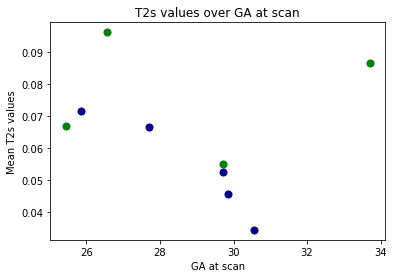

In [181]:
import matplotlib.pyplot as plt
x=gas
y=t2s_values
print(x)
print(y)

indicescontrol=[0,1,2,3,4]
xcontrol = []
ycontrol=[]
for index in indicescontrol:
    xcontrol.append(x[index])
    ycontrol.append(y[index])
    
indicesinf=[5,6,7,8]
xinf = []
yinf=[]
for index in indicesinf:
    xinf.append(x[index])
    yinf.append(y[index])

ax.grid(zorder=0)
plt.scatter(xcontrol, ycontrol,s=50, c='darkblue')
plt.scatter(xinf, yinf,s=50, c='green')

plt.title('T2s values over GA at scan')


plt.xlabel('GA at scan')
plt.ylabel('Mean T2s values')

plt.show()



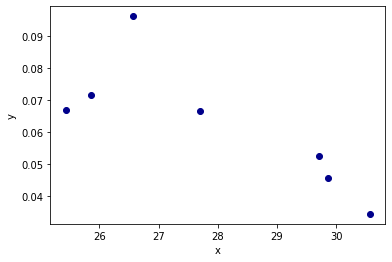

In [177]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([27.7,29.86,30.57,25.86,29.71,26.57,25.43])
y = np.array([0.0665305200747051,0.04577661330073078,0.03447009214907587,0.07148857147893063,0.05264771168045016,0.09609188032461496,0.06672493735215487])
plt.scatter(x, y, c='darkblue')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.show()

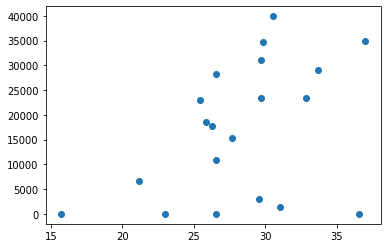

In [178]:
import matplotlib.pyplot as plt
x=gas
y=vol_values
plt.scatter(x,y)
plt.show()


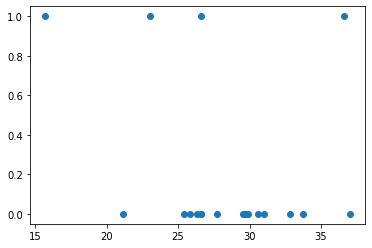

In [179]:
import matplotlib.pyplot as plt
x=gas
y=adc_values
plt.scatter(x,y)
plt.show()


In [195]:
#Some more complex models that might be interesting to explore..
#T2ball-T2ball (T2-IVIM) model - two compartment model
T2ADC_compartment1 = gaussian_models.G1BallT2()
T2ADC_compartment2 = gaussian_models.G1BallT2()

T2IVIMmod = MultiCompartmentModel([T2ADC_compartment1, T2ADC_compartment2])
#one compartment is perfusion - adjust parameter ranges accordingly 
T2IVIMmod.parameter_ranges['G1BallT2_1_lambda_iso'] = (3, 100)



#DECIDE model - T2ball-T2ball-T2ball with linked parameters (Andrew Melbourne et al MRM 2018)
#compartment 1: fetal blood - D_1 (high), T2_1 (high)
#compartment 2: maternal blood - D_2 (low), T2_1 (high)
#compartment 3: tissue - D_2 (low), T2_2 (low)

T2ADC_compartment1 = gaussian_models.G1BallT2()
T2ADC_compartment2 = gaussian_models.G1BallT2()
T2ADC_compartment3 = gaussian_models.G1BallT2()

decidemod = MultiCompartmentModel([T2ADC_compartment1, T2ADC_compartment2, T2ADC_compartment3])

#need to set diffusivities equal for maternal blood and tissue
decidemod.set_equal_parameter('G1BallT2_2_lambda_iso', 'G1BallT2_3_lambda_iso')
#set t2 equal for maternal blood and fetal blood
decidemod.set_equal_parameter('G1BallT2_1_t2', 'G1BallT2_2_t2')

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing numba for faster function execution and model fitting.
